In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
from src.dataloader import *
from src.utils import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

import matplotlib.pyplot as plt

In [2]:
ds_train_sr = pickle.load(open('/home/jupyter/data/saved_datasets/testdataset_single_forecast_tp_pure_sr_first_days_5.pkl','rb'))
ds_train = pickle.load(open('/home/jupyter/data/saved_datasets/testdataset_single_forecast_tp_log_trans_first_days_5.pkl', 'rb'))


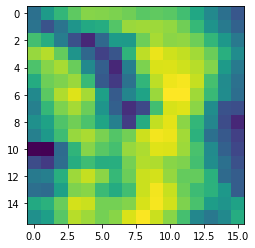

In [13]:
plt.imshow(ds_train[0][0].squeeze())

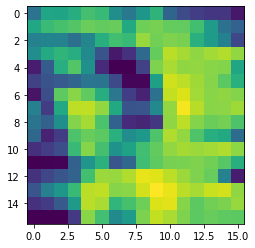

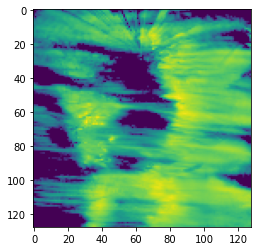

In [11]:
plt.figure()
plt.imshow(ds_train_sr[0][0].squeeze())
plt.figure()
plt.imshow(ds_train_sr[0][1].squeeze())

In [267]:
# ds = pickle.load(open('/home/jupyter/data/saved_datasets/testdataset_ensemble_tp_extra_vars_TCW_x10_padded_10_channel_first_days_5.pkl', 'rb'))
ds = pickle.load(open('/home/jupyter/data/saved_datasets/traindataset_ensemble_tp_extra_vars_TCW_x10_padded_10_channel.pkl', 'rb'))
ds_log_01 = pickle.load(open('/home/jupyter/data/saved_datasets/testdataset_ensemble_tp_extra_vars_TCW_x10_log_trans_padded_10_channel_first_days_5.pkl', 'rb'))

In [268]:
ds[0][1]

array([[[0.08674387, 0.14136037, 0.3983792 , ..., 0.44335756,
         0.39837924, 0.32448632],
        [0.01285094, 0.12208395, 0.12208395, ..., 0.37267736,
         0.28593346, 0.1991896 ],
        [0.        , 0.        , 0.04176556, ..., 0.20240235,
         0.1991896 , 0.2056151 ],
        ...,
        [0.        , 0.03212736, 0.16384953, ..., 1.728452  ,
         1.9790453 , 2.2874677 ],
        [0.01927642, 0.09638207, 0.16063678, ..., 1.6449207 ,
         1.9918962 , 2.4031262 ],
        [0.00321274, 0.07389292, 0.09316934, ..., 1.606368  ,
         2.2103622 , 2.8753984 ]]], dtype=float32)

1.0526955

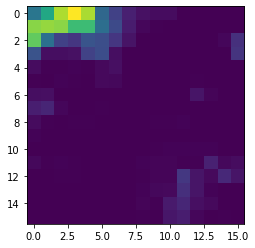

In [286]:
s = 18
plt.imshow(ds[s][0][0,:,:])
# ds[0][0].shape
np.max(ds[s][0][0,:,:])

7.7009273

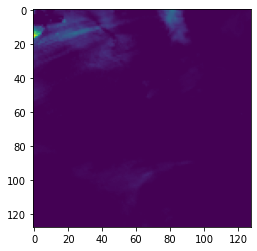

In [287]:
plt.imshow(ds[s][1][0,:,:])
np.max(ds[s][1][0,:,:])

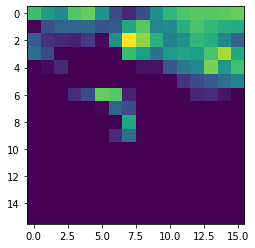

In [271]:
plt.imshow(ds_log_01[9][0][0,:,:])

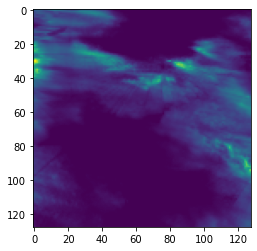

In [255]:
plt.imshow(ds[0][1][0])

In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from src.models import *
# from src.dataloader import *
from src.utils import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

import matplotlib.pyplot as plt

import pandas as pd

from skimage.transform import resize

In [30]:

def log_trans(x, eps):
    """Log transform with given epsilon. Preserves zeros."""
#     return np.log(x + eps) - np.log(eps)
    return np.sqrt(x)

def log_retrans(x, eps):
    """Inverse log transform"""
#     return np.exp(x + np.log(eps)) - eps
    return np.square(x)

class TiggeMRMSDataset(Dataset):
    """ PyTorch Dataset for TIGGE MRMS pairing.
    
    Returns TiggeMRMSDataset object. 
    
    self.idxs: numpy array with three columns: 
        [first, second, third] column corresponds to
        [time,  lat,    lon  ] index of the patches. 
        The time-idx value corresponds to the time given by the overlap_times array.

            
    """
    def __init__(self, tigge_dir, tigge_vars, mrms_dir, lead_time=12, patch_size=512, rq_fn=None, 
                 const_fn=None, const_vars=None, scale=True, data_period=None, first_days=None,
                 val_days=None, split=None, mins=None, maxs=None, pad_tigge=0, pad_tigge_channel = True, tp_log=None,
                 cat_bins=None, pure_sr_ratio=None, dropna=True, ensemble_mode=None):
        """
        tigge_dir: Path to TIGGE data without variable name
        tigge_vars: List of TIGGE variables
        mrms_dir: Path to MRMS data including variable name
        lead_time: Lead time of TIGGE data. 12h means 6-12h accumulation
        patch_size: Size of patch in km
        rq_fn: Path to radar quality file
        const_fn: Path to constants file
        cons_vars: Variables to use from constants file
        data_period: Tuple indicating which time period to load
        val_days: Use first N days of each month for validation
        first_days: Use first X days from each month. Subsampling.
        split: Either "train" or "valid"
        scale: Do min-max scaling
        mins: Dictionary of mins for TIGGE vars. Computed if not given.
        maxs: Same for maxs
        pad_tigge: Padding to add to TIGGE patches on each side.
        tp_log: whether to scale the total precipitation logarithmically. 
        """
        self.lead_time = lead_time
        self.patch_size = patch_size
        self.first_days = first_days
        self.val_days = val_days
        self.split= split
        self.cat_bins = cat_bins
        self.pure_sr_ratio = pure_sr_ratio
        self.tp_log = tp_log
        self.ensemble_mode = ensemble_mode
        self.tigge_vars = tigge_vars
        # Open datasets
        self.tigge = xr.merge([
            xr.open_mfdataset(f'{tigge_dir}/{v}/*.nc') for v in tigge_vars
        ])  # Merge all TIGGE variables
               
        if 'convective_inhibition' in tigge_vars:
            print("setting nans in convective_inhibition to 0")
            self.tigge['cin'] = self.tigge['cin'].fillna(0)
        
        self.tigge['tp'] = self.tigge.tp.diff('lead_time')   # Need to take diff to get 6h accumulation
        self.tigge = self.tigge.sel(lead_time=np.timedelta64(lead_time, 'h'))
        self.mrms = xr.open_mfdataset(f'{mrms_dir}/*.nc').tp   # NOTE: Takes around 30s
        # Make sure there are no negative values
        self.tigge['tp'] = self.tigge['tp'].where(self.tigge['tp'] >= 0, 0)  
        self.mrms = self.mrms.where(self.mrms >= 0, 0)
        if data_period:   # NOTE: This will not speed up the open_mfdataset step
            self.tigge = self.tigge.sel(init_time=slice(*data_period))
            self.mrms = self.mrms.sel(time=slice(*data_period))
#         import pdb; pdb.set_trace()
        if dropna:
            self.tigge.load()
            self.tigge = self.tigge.dropna('init_time')
        self._crop_times()   # Only take times that overlap and (potentially) do train/val split
        print('Loading data')
        self.tigge.load(); self.mrms.load()   # Load datasets into RAM
        if tp_log:
            self.tigge['tp'] = log_trans(self.tigge['tp'], tp_log)
            if cat_bins is None:   # No log transform for categorical output
                self.mrms = log_trans(self.mrms, tp_log)
        
        if scale:   # Apply min-max scaling
            self._scale(mins, maxs, scale_mrms=True if cat_bins is None else False)
          
        # Doing this here saves time
        self.tigge = self.tigge.to_array()
        
        self.tigge_km = 32 # ds.tigge.lon.diff('lon').max()*100  # Currently hard-coded 
        self.mrms_km = 4
        self.ratio = self.tigge_km // self.mrms_km
        self.pad_tigge = pad_tigge
        self.pad_tigge_channel = pad_tigge_channel
        self.pad_mrms = self.pad_tigge * self.ratio
        self.patch_tigge = self.patch_size // self.tigge_km
        self.patch_mrms = self.patch_size // self.mrms_km
        
        if rq_fn:  # Create mask of regions with radar coverage
            self._create_rqmask(rq_fn)
        self._setup_indices()   # Set up sample indices (time, lat, lon)
        
        if const_fn:  # Open and scale constants file
            self.const = xr.open_dataset(const_fn).load()
            self.const_vars = const_vars
            if scale:
                const_mins = self.const.min()
                const_maxs = self.const.max()
                self.const = (self.const - const_mins) / (const_maxs - const_mins)
            self.const = self.const[self.const_vars].to_array()
    
    def _scale(self, mins, maxs, scale_mrms=True):
        """Apply min-max scaling. Use same scaling for tp in TIGGE and MRMS."""
        self.mins = mins or self.tigge.min()   # Use min/max if provided, otherwise compute
        self.maxs = maxs or self.tigge.max()
        
        if self.cat_bins is None:
            self.maxs['tp'] = self.mrms.max()   # Make sure to take MRMS max for tp
        self.tigge = (self.tigge - self.mins) / (self.maxs - self.mins)
        if scale_mrms:
            self.mrms = (self.mrms - self.mins.tp) / (self.maxs.tp - self.mins.tp)
            
# #         Use min/max if provided, otherwise compute
        
#         self.mins = mins or {i:self.tigge[i].min().astype('float32') for i in list(self.tigge.data_vars)}
#         self.maxs = maxs or {i:self.tigge[i].max().astype('float32') for i in list(self.tigge.data_vars)}
        
#         if (self.cat_bins is None) and (maxs is None):
#             self.maxs['tp'] = self.mrms.max()   # Make sure to take MRMS max for tp
        
#         self.scaled_tigge_std = {}    
#         for i in list(self.tigge.data_vars):
#             self.tigge[i] = (self.tigge[i] - self.mins[i]) / (self.maxs[i] - self.mins[i])
#             self.scaled_tigge_std[i] = self.tigge[i].std()
# #             self.tigge[i] = self.tigge[i] / self.scaled_tigge_std[i]
#         if scale_mrms:
#             self.mrms = (self.mrms - self.mins['tp']) / (self.maxs['tp'] - self.mins['tp'])
# #             self.mrms = self.mrms/self.scaled_tigge_std['tp']
                             
        
    def _crop_times(self):
        """Crop TIGGE and MRMS arrays to where they overlap"""
        # Make TIGGE file have valid_time as dimension
        valid_time = self.tigge.init_time + self.tigge.lead_time
        self.tigge.coords['valid_time'] = valid_time
        self.tigge = self.tigge.swap_dims({'init_time': 'valid_time'})

        # Compute intersect
        self.overlap_times = np.intersect1d(self.mrms.time, self.tigge.valid_time)

        if self.first_days: # Only select first X days
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[dt.day <= self.first_days]
        if self.val_days: # Split into train and valid based on day of month
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[
                dt.day <= self.val_days if self.split == 'valid' else dt.day > self.val_days
            ]
        
        # Apply selection
        self.mrms = self.mrms.sel(time=self.overlap_times)
        self.tigge = self.tigge.sel(valid_time=self.overlap_times)
        
    def _setup_indices(self):
        """Create a list of indices containing (time, lat_idx, lon_idx). _idx is the patch index."""
        # Account for padding on each side
        nlat = (len(self.tigge.lat) - 2*self.pad_tigge)  // self.patch_tigge
        nlon = (len(self.tigge.lon) - 2*self.pad_tigge) // self.patch_tigge
        # This creates indices with (lat_idx, lon_idx)
        idxs = np.array([g.flatten() for g in np.mgrid[:nlat, :nlon]]).T
        if hasattr(self, 'rqmask'):   # Only take indices where radar coverage is available
            idxs = np.array([r for r in idxs if self.rqmask.isel(lat=r[0], lon=r[1])])
        # Now add time indices
        self.ntime = len(self.overlap_times)
        self.idxs = np.concatenate([
            np.concatenate(
                [np.ones((len(idxs), 1), dtype=int)*i, idxs], 1
            ) for i in range(self.ntime)
        ])
    
    def _create_rqmask(self, rq_fn):
        """Coarsen radar mask to patch and check for full coverage"""
        rq = xr.open_dataarray(rq_fn)
        # Account for padding
        rq = rq.isel(lat=slice(self.pad_mrms, -self.pad_mrms or None), lon=slice(self.pad_mrms, -self.pad_mrms or None))
        self.rqmask = rq.coarsen(lat=self.patch_mrms, lon=self.patch_mrms, boundary='trim').min() >= 0
        
    def __len__(self):
        return len(self.idxs)

    @property
    def input_vars(self):
        v = len(self.tigge.variable)
        if hasattr(self, 'const'):
            v += len(self.const.variable)
        return v
    
    def __getitem__(self, idx, time_idx=None, full_array=False, no_cat=False):
        """Return individual sample. idx is the sample id, i.e. the index of self.idxs.
        X: TIGGE sample
        y: corresponding MRMS (radar) sample
        
        **Attention:**
        The self.tigge latitude variable is from ~50-20 degrees, i.e. not from small to large!
        Be careful when transforming indices to actual latitude values! 
        
        """

        if torch.is_tensor(idx):
            idx = idx.tolist()
        time_idx_tmp, lat_idx, lon_idx = self.idxs[idx]
        time_idx = time_idx or time_idx_tmp

        # Get features for given time and patch
        if full_array:  # Return full lats, lons
            lat_slice = slice(0, None)
            lon_slice = slice(0, None)
        else:
            lat_slice = slice(lat_idx * self.patch_tigge, (lat_idx+1) * self.patch_tigge + self.pad_tigge*2)
            lon_slice = slice(lon_idx * self.patch_tigge, (lon_idx+1) * self.patch_tigge + self.pad_tigge*2)
            
        X = self.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
        if self.ensemble_mode == 'stack':
            X = X.rename({'variable': 'raw_variable'}).stack(variable = ['raw_variable', 'member']).transpose(
                'variable', 'lat', 'lon')
        if self.ensemble_mode == 'random':
            member_idx = np.random.choice(self.tigge.member)
            X = X.sel(member=member_idx)
        X = X.values
        if hasattr(self, 'const'):  # Add constants
            X = self._add_const(X, lat_slice, lon_slice)
        

        # Get targets
        if full_array:   # Return corresponding MRMS slice; not used currently
            lat_slice = slice(0, len(self.tigge.lat) * self.ratio)
            lon_slice = slice(0, len(self.tigge.lon) * self.ratio)
        else:
            lat_slice = slice(
                lat_idx * self.patch_mrms + self.pad_mrms, 
                (lat_idx+1) * self.patch_mrms + self.pad_mrms
            )
            lon_slice = slice(
                lon_idx * self.patch_mrms + self.pad_mrms, 
                (lon_idx+1) * self.patch_mrms + self.pad_mrms
            )
        y = self.mrms.isel(
            time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        ).values[None]  # Add dimension for channel
        if self.pure_sr_ratio:
            X = self._make_sr_X(y)
        if self.cat_bins is not None and not no_cat:
            y = self._categorize(y)
            
        if self.pad_tigge_channel:
            X_crop = X[:,self.pad_tigge:self.pad_tigge + self.patch_tigge, self.pad_tigge:self.pad_tigge + self.patch_tigge]
            X_downsample = resize(X[0:1,:,:], (1, self.patch_tigge, self.patch_tigge))
            X = np.concatenate((X_crop, X_downsample), axis=0)
        return X.astype(np.float32), y.astype(np.float32)   # [vars, patch, patch]
    
    def _add_const(self, X, lat_slice, lon_slice):
        """Add constants to X"""
        Xs = [X]
        Xs.append(self.const.isel(
            lat=lat_slice,
            lon=lon_slice
        ))
        return np.concatenate(Xs)
    
    def _make_sr_X(self, y):
        X = block_reduce(y, (1, self.pure_sr_ratio, self.pure_sr_ratio), np.mean)
        return X


    def _categorize(self, y):
        """Converts continuous output to one-hot-encoded categories"""
        y_shape = y.shape
        y = pd.cut(y.reshape(-1), self.cat_bins, labels=False, include_lowest=True).reshape(y_shape)
        # y = to_categorical(y.squeeze(), num_classes=len(self.cat_bins))
        # y = np.rollaxis(y, 2)
        return y.squeeze().astype('int')
    
    def return_full_array(self, time_idx):
        """Shortcut to return a full scaled array for a single time index"""
        return self.__getitem__(0, time_idx, full_array=True)


    def compute_weights(self, min_weight=0.02, max_weight=0.4, threshold=0.025, exp=4, 
                        compute_on_X=False):
        """
        Compute sampling weights for each sample. WEight is simply the mean precip
        value of the target, clipped.
        This can then be used in torch.utils.data.WeightedRandomSampler, for example.
        """
        # Get the mean precipitation from MRMS for each sample
        # mean_precip = []
        # for idx in range(len(self.idxs)):
        #     X, y = self.__getitem__(idx, no_cat=True)
        #     mean_precip.append(y.mean())
        # weights = np.clip(mean_precip, 0.01, 0.1)

        if self.tp_log: threshold = log_trans(threshold, self.tp_log)

        coverage = []
        for idx in range(len(self.idxs)):
            X, y = self.__getitem__(idx, no_cat=True)
            if compute_on_X: y = X
            y = y > threshold
            coverage.append(y.mean())
        scale = max_weight - min_weight
        x = 1-(np.array(coverage)-1)**exp
        weights = min_weight + x * scale


        # # Compute histogram
        # bin_weight = np.histogram(coverage, bins=bins)[0]
        # # Weight for each bin is simply the inverse frequency.
        # bin_weight = 1 / np.maximum(bin_weight, 1)
        # # Get weight for each sample
        # bin_idxs = np.digitize(coverage, bins) - 1
        # weights = bin_weight[bin_idxs]
        return weights

    def get_settings(self): 
        """returns key properties as pandas table"""

        options=pd.DataFrame()
        for key, value in iter(vars(self).items()):
            if not key in ['tigge', 'mrms', 'overlap_times', 'mins','maxs', 'rqmask','idxs']:
                options[key] = [value]

        options = options.transpose()
        options.columns.name='TiggeMRMSDataset_Settings:'
        return options

In [31]:
data_dir = '/home/jupyter/data/'
args = {'tigge_dir':data_dir + f'tigge/32km/',
    'tigge_vars':['total_precipitation_ens10','total_column_water_ens10'],#, '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition'],
    'mrms_dir':data_dir + f'mrms/4km/RadarOnly_QPE_06H/',
    'rq_fn':data_dir + f'mrms/4km/RadarQuality.nc',
#     'const_fn':data_dir + 'tigge/32km/constants.nc',
#     'const_vars':['orog', 'lsm'],
    'data_period':('2018-01', '2018-02'),
    'val_days':5,
    'split':'train',
#     'pure_sr_ratio':8, 
    'tp_log':0.1, 
    'ensemble_mode':'random',
    'pad_tigge':10,
    'pad_tigge_channel': True, 
    'scale': True
    }

In [32]:
ds = TiggeMRMSDataset(**args)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/ilan/lib/pyt

KeyboardInterrupt: 

In [76]:
maxtp = ds.tigge[0].max().values
mintp = ds.tigge[0].min().values

In [77]:
print(ds.tigge[0].mean().values)
print(ds.tigge[0].std().values)
print(ds.tigge[0].max().values)
print(ds.tigge[0].min().values)


0.021670335605965676
0.04172526487985421
0.7878864672136647
0.0


In [78]:
print(ds.tigge[1].mean().values)
print(ds.tigge[1].std().values)
print(ds.tigge[1].max().values)
print(ds.tigge[1].min().values)


0.18335305787719025
0.1458883155153976
1.0
0.0


In [79]:
print(ds.mrms.mean().values)
print(ds.mrms.std().values)
print(ds.mrms.max().values)
print(ds.mrms.min().values)

0.0102428336585417
0.034795031231080166
1.0
0.0


In [80]:
# np.log(100 + 0.5) - np.log(0.5)

In [81]:
np.log(1+0)

0.0

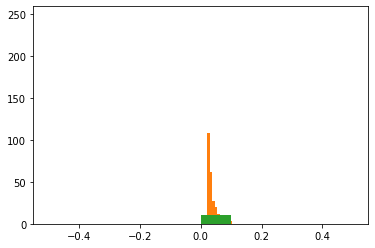

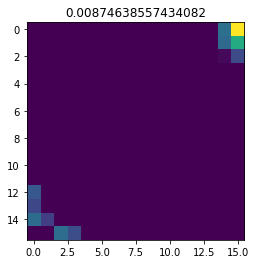

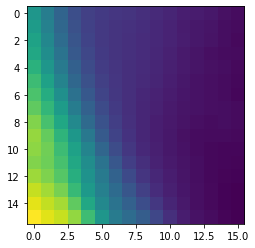

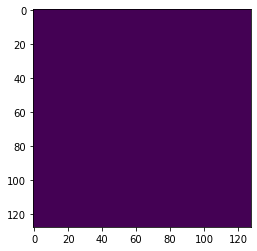

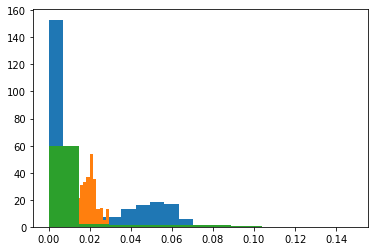

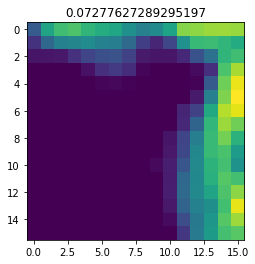

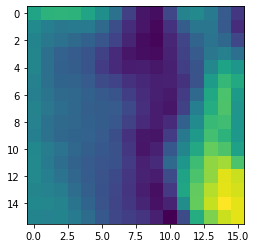

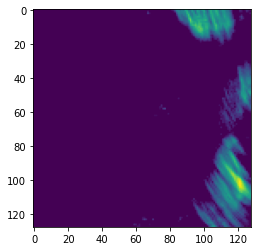

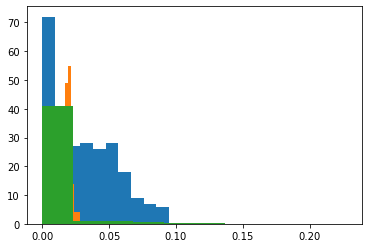

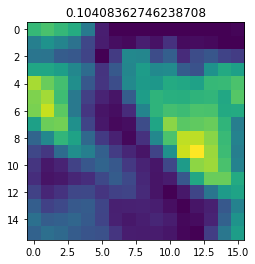

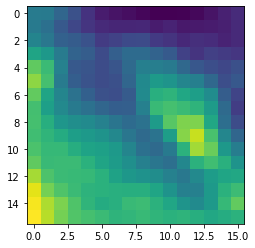

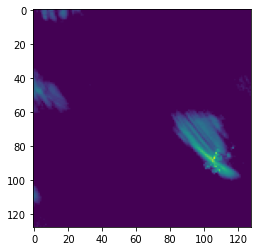

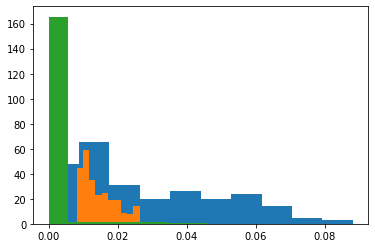

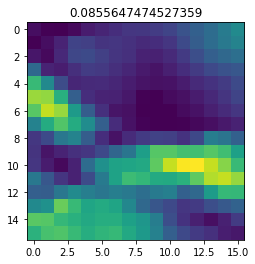

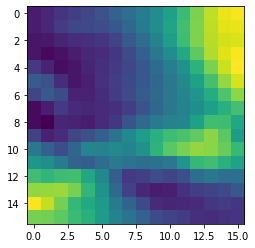

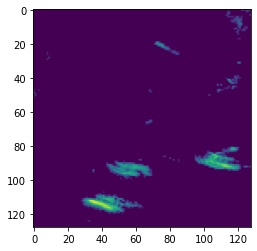

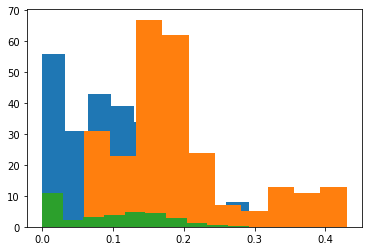

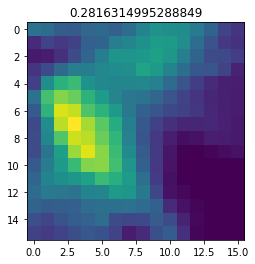

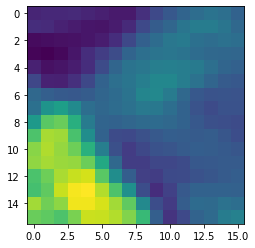

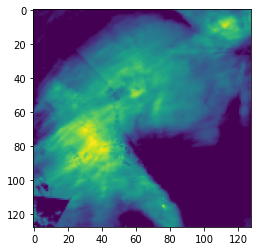

In [82]:
for i in range(5,10):
    plt.figure()
    plt.hist(np.reshape(ds[i][0][0,:,:], -1))
    plt.hist(np.reshape(ds[i][0][1,:,:], -1))
    plt.hist(np.reshape(ds[i][1], -1), density=True);
#     plt.hist(log_trans(np.reshape(ds[i][0][0,:,:], -1)/maxtp, 0.01));
    plt.figure()
    plt.imshow(ds[i][0][0,:,:])
    plt.title(f'{np.max(ds[i][0][0,:,:])}')
    plt.figure()
    plt.imshow(ds[i][0][1,:,:])
    plt.figure()
    plt.imshow(ds[i][1][0,:,:])
    
    
    
    
#     plt.figure()
#     plt.hist(np.reshape(ds_log_01[i][0][0,:,:], -1));
# #     plt.hist(np.reshape(ds_log_01[i][0][1,:,:], -1));

# plt.figure()
# plt.hist(np.reshape(ds[0][0][2,:,:], -1));

In [73]:
c = 0
for t in range(101):
    if (ds.tigge[0,:,t,:,:]>30).sum()>0:
        c+=1
c

IndexError: index 78 is out of bounds for axis 2 with size 78

In [226]:
c = 0
for t in range(100):
    if (ds.mrms[t,:,:]>0.9).sum()>0:
        c+=1
        
c

66

In [225]:
ds.tigge[1].max()

<xarray.DataArray ()>
array(7.87643407)
Coordinates:
    lead_time  timedelta64[ns] 12:00:00
    variable   <U3 'tcw'

In [218]:
m = 0
for i in ds:
    m = max(np.max(i[0][0]), m)
m

39.1445

In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
from src.dataloader import *
from src.utils import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

## Train and Val

In [2]:
data_dir = '/home/jupyter/data/'

In [3]:
args = {'tigge_dir':data_dir + f'tigge/32km/',
    'tigge_vars':['total_precipitation', 'total_column_water'],#, '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition'],
    'mrms_dir':data_dir + f'mrms/4km/RadarOnly_QPE_06H/',
    'rq_fn':data_dir + f'mrms/4km/RadarQuality.nc',
#     'const_fn':data_dir + 'tigge/32km/constants.nc',
#     'const_vars':['orog', 'lsm'],
    'data_period':('2018-01', '2018-02'),
    'val_days':5,
    'split':'train',
#     'pure_sr_ratio':8, 
    'tp_log':0.01, 
#     'ensemble_mode':'random',
    'pad_tigge':10, 
     'pad_tigge_channel': True
    }

dataset_name = 'ensemble_forecast_x10_random_log_trans_padded_24'

In [4]:
ds_train = TiggeMRMSDataset(**args)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


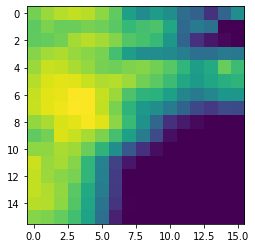

In [5]:
plt.imshow(ds_train[1][0][0])

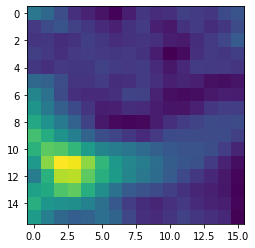

In [6]:
plt.imshow(ds_train[1][0][1])

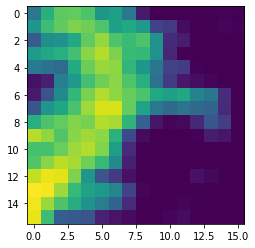

In [7]:
plt.imshow(ds_train[1][0][2])

In [8]:
ds_train[1][0].shape

(3, 16, 16)

In [26]:
time_idx = 9
lat_idx=0
lon_idx =1

lat_slice = slice(lat_idx * 16, (lat_idx+1) * 16 + 10*2)
lon_slice = slice(lon_idx * 16, (lon_idx+1) * 16 + 10*2)
            
X = ds_train.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
X = X.values

DescribeResult(nobs=1296, minmax=(0.0, 0.3872196685336464), mean=0.01302332708065118, variance=0.0020403244794664865, skewness=4.551215856878349, kurtosis=22.832084656526817)
DescribeResult(nobs=1296, minmax=(0.0072600357234478, 0.15032412111759186), mean=0.06632667835327555, variance=0.0007933665565498303, skewness=0.31522096160026286, kurtosis=-0.7402382361029818)
________________
DescribeResult(nobs=1296, minmax=(0.0, 0.41025969542877627), mean=0.02071284046517443, variance=0.0045249064871544465, skewness=3.675962369590254, kurtosis=12.942036937792015)
DescribeResult(nobs=1296, minmax=(0.010127630084753036, 0.18593132495880127), mean=0.06691441287496415, variance=0.0018859004706532512, skewness=0.8001016757681065, kurtosis=-0.5076593151453976)
________________
DescribeResult(nobs=1296, minmax=(0.0, 0.24295261772309396), mean=0.005038937885809055, variance=0.0004416553797990026, skewness=6.750997511485361, kurtosis=53.99154433245168)
DescribeResult(nobs=1296, minmax=(0.00316421454772

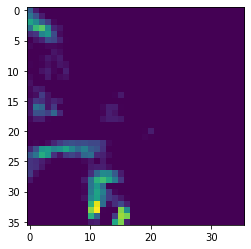

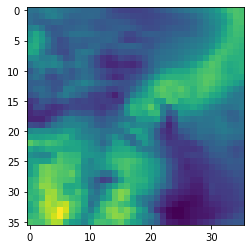

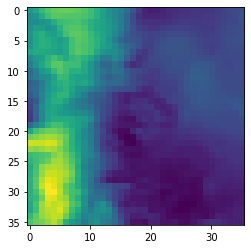

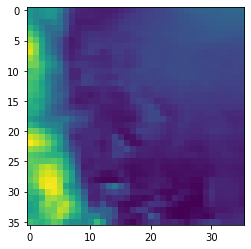

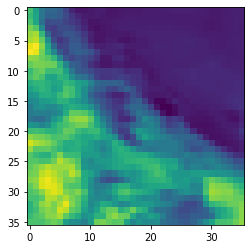

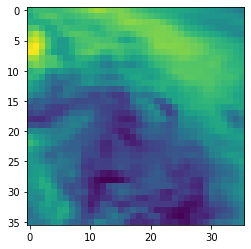

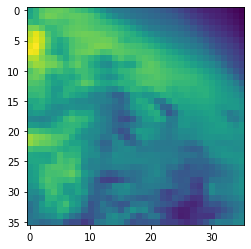

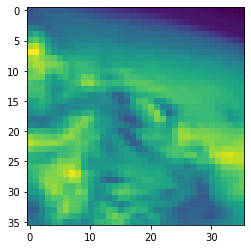

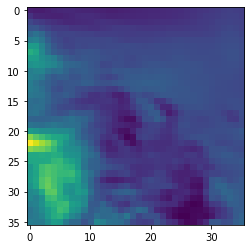

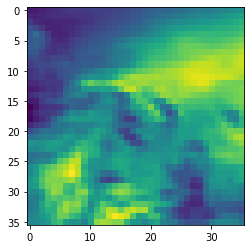

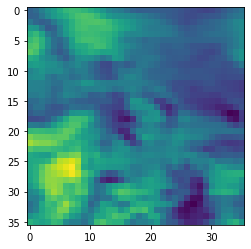

In [44]:
import scipy as sp
idx = 350
time_idx, lat_idx, lon_idx  = ds_train.idxs[idx]

lat_slice = slice(lat_idx * 16, (lat_idx+1) * 16 + 10*2)
lon_slice = slice(lon_idx * 16, (lon_idx+1) * 16 + 10*2)
            
X = ds_train.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
X = X.values

plt.figure()
plt.imshow(X[0])

for i in range(10):
    time_idx, lat_idx, lon_idx  = ds_train.idxs[idx]
    time_idx-=i

    lat_slice = slice(lat_idx * 16, (lat_idx+1) * 16 + 10*2)
    lon_slice = slice(lon_idx * 16, (lon_idx+1) * 16 + 10*2)

    X = ds_train.tigge.isel(
                valid_time=time_idx,
                lat=lat_slice,
                lon=lon_slice
            )
    X = X.values

#     plt.figure()
#     plt.imshow(X[0])
    plt.figure()
    plt.imshow(X[1])
    print(sp.stats.describe(X[0], axis=None))
    print(sp.stats.describe(X[1], axis=None))
    print('________________')



In [19]:
ds_train.idxs[1]

array([0, 0, 1])

In [57]:
sp.stats.describe(ds_train.tigge[0].values, axis = None)

DescribeResult(nobs=1247688, minmax=(0.0, 0.9170368698469178), mean=0.13990598754070277, variance=0.039025520242682445, skewness=1.219238611995331, kurtosis=0.23546853488798236)

In [63]:
def log_trans(x, eps):
    """Log transform with given epsilon. Preserves zeros."""
    return np.log(x + eps) - np.log(eps)

(array([4.28333e+05, 3.35362e+05, 1.59919e+05, 1.24783e+05, 1.04737e+05,
        6.39130e+04, 2.81710e+04, 2.42900e+03, 3.80000e+01, 3.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

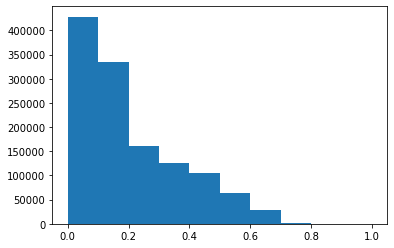

In [68]:
plt.hist(np.reshape(ds_train.tigge[1].values, -1))

(array([7.73242e+05, 8.37070e+04, 8.55880e+04, 8.97400e+04, 8.29120e+04,
        6.50370e+04, 4.36990e+04, 2.01640e+04, 3.51300e+03, 8.60000e+01]),
 array([0.        , 0.09170369, 0.18340737, 0.27511106, 0.36681475,
        0.45851843, 0.55022212, 0.64192581, 0.7336295 , 0.82533318,
        0.91703687]),
 <BarContainer object of 10 artists>)

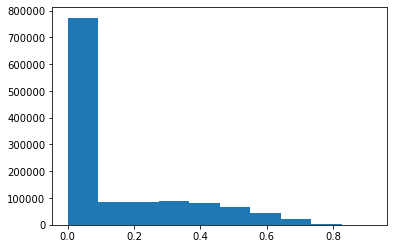

In [62]:
plt.hist(np.reshape(ds_train.tigge[0].values, -1))

In [54]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [55]:
a = np.random.randint(255,size=(16,16, 3))

In [56]:
np.savez_compressed('./test', a)

In [57]:
from PIL import Image
im = Image.fromarray(a.astype(np.uint8))
im.save("./test.jpeg")

In [58]:
from skimage import data, io, filters

In [59]:
import timeit

start = timeit.timeit()
io.imread('./test.jpeg')
end = timeit.timeit()
print(end - start)



0.0010096789337694645


In [60]:
start = timeit.timeit()
np.load('./test.npz')
end = timeit.timeit()
print(end - start)

0.00015725998673588037


In [2]:
import torch
from torch.utils.data import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from src.utils import tqdm, device, to_categorical
# from src.dataloader import *
from skimage.measure import block_reduce
from skimage.transform import resize

def log_trans(x, eps):
    """Log transform with given epsilon. Preserves zeros."""
    return np.log(x + eps) - np.log(eps)

def log_retrans(x, eps):
    """Inverse log transform"""
    return np.exp(x + np.log(eps)) - eps


class TiggeMRMSDataset(Dataset):
    """ PyTorch Dataset for TIGGE MRMS pairing.
    
    Returns TiggeMRMSDataset object. 
    
    self.idxs: numpy array with three columns: 
        [first, second, third] column corresponds to
        [time,  lat,    lon  ] index of the patches. 
        The time-idx value corresponds to the time given by the overlap_times array.

            
    """
    def __init__(self, tigge_dir, tigge_vars, mrms_dir, lead_time=12, patch_size=512, rq_fn=None, 
                 const_fn=None, const_vars=None, scale=True, data_period=None, first_days=None,
                 val_days=None, split=None, mins=None, maxs=None, pad_tigge=0, pad_tigge_channel=False, tp_log=None,
                 cat_bins=None, pure_sr_ratio=None, dropna=True, ensemble_mode=None, idx_stride=1):
        """
        tigge_dir: Path to TIGGE data without variable name
        tigge_vars: List of TIGGE variables
        mrms_dir: Path to MRMS data including variable name
        lead_time: Lead time of TIGGE data. 12h means 6-12h accumulation
        patch_size: Size of patch in km
        rq_fn: Path to radar quality file
        const_fn: Path to constants file
        cons_vars: Variables to use from constants file
        data_period: Tuple indicating which time period to load
        val_days: Use first N days of each month for validation
        first_days: Use first X days from each month. Subsampling.
        split: Either "train" or "valid"
        scale: Do min-max scaling
        mins: Dataset of mins for TIGGE vars. Computed if not given.
        maxs: Same for maxs
        pad_tigge: Padding to add to TIGGE patches on each side.
        tp_log: whether to scale the total precipitation logarithmically. 
        """
        self.lead_time = lead_time
        self.patch_size = patch_size
        self.first_days = first_days
        self.val_days = val_days
        self.split= split
        self.cat_bins = cat_bins
        self.pure_sr_ratio = pure_sr_ratio
        self.tp_log = tp_log
        self.ensemble_mode = ensemble_mode
        self.tigge_vars = tigge_vars
        self.idx_stride = idx_stride
        # Open datasets
        self.tigge = xr.merge([
            xr.open_mfdataset(f'{tigge_dir}/{v}/*.nc') for v in tigge_vars
        ])  # Merge all TIGGE variables
               
        if 'convective_inhibition' in tigge_vars:
            print("setting nans in convective_inhibition to 0")
            self.tigge['cin'] = self.tigge['cin'].fillna(0)
        
        self.tigge['tp'] = self.tigge.tp.diff('lead_time')   # Need to take diff to get 6h accumulation
        self.tigge = self.tigge.sel(lead_time=np.timedelta64(lead_time, 'h'))
        self.mrms = xr.open_mfdataset(f'{mrms_dir}/*.nc').tp   # NOTE: Takes around 30s
        # Make sure there are no negative values
        self.tigge['tp'] = self.tigge['tp'].where(self.tigge['tp'] >= 0, 0)  
        self.mrms = self.mrms.where(self.mrms >= 0, 0)
        if data_period:   # NOTE: This will not speed up the open_mfdataset step
            self.tigge = self.tigge.sel(init_time=slice(*data_period))
            self.mrms = self.mrms.sel(time=slice(*data_period))
#         import pdb; pdb.set_trace()
        if dropna:
            self.tigge.load()
            self.tigge = self.tigge.dropna('init_time')
        self._crop_times()   # Only take times that overlap and (potentially) do train/val split
        print('Loading data')
        self.tigge.load(); self.mrms.load()   # Load datasets into RAM
        if tp_log:
            self.tigge['tp'] = log_trans(self.tigge['tp'], tp_log)
            if cat_bins is None:   # No log transform for categorical output
                self.mrms = log_trans(self.mrms, tp_log)
        
        if scale:   # Apply min-max scaling
            self._scale(mins, maxs, scale_mrms=True if cat_bins is None else False)
          
        # Doing this here saves time
        self.tigge = self.tigge.to_array()
        
        self.tigge_km = 32 # ds.tigge.lon.diff('lon').max()*100  # Currently hard-coded 
        self.mrms_km = 4
        self.ratio = self.tigge_km // self.mrms_km
        self.pad_tigge = pad_tigge
        self.pad_tigge_channel = pad_tigge_channel
        self.pad_mrms = self.pad_tigge * self.ratio
        self.patch_tigge = self.patch_size // self.tigge_km
        self.patch_mrms = self.patch_size // self.mrms_km
        
        if rq_fn:  # Create mask of regions with radar coverage
            self._create_rqmask(rq_fn)
        self._setup_indices()   # Set up sample indices (time, lat, lon)
        
        if const_fn:  # Open and scale constants file
            self.const = xr.open_dataset(const_fn).load()
            self.const_vars = const_vars
            if scale:
                const_mins = self.const.min()
                const_maxs = self.const.max()
                self.const = (self.const - const_mins) / (const_maxs - const_mins)
            self.const = self.const[self.const_vars].to_array()
    
    def _scale(self, mins, maxs, scale_mrms=True):
        """Apply min-max scaling. Use same scaling for tp in TIGGE and MRMS."""

        self.mins = mins or self.tigge.min()   # Use min/max if provided, otherwise compute
        self.maxs = maxs or self.tigge.max()
        
        if self.cat_bins is None:
            self.maxs['tp'] = self.mrms.max()   # Make sure to take MRMS max for tp
        self.tigge = (self.tigge - self.mins) / (self.maxs - self.mins)
        if scale_mrms:
            self.mrms = (self.mrms - self.mins.tp) / (self.maxs.tp - self.mins.tp)
                             
        
    def _crop_times(self):
        """Crop TIGGE and MRMS arrays to where they overlap"""
        # Make TIGGE file have valid_time as dimension
        valid_time = self.tigge.init_time + self.tigge.lead_time
        self.tigge.coords['valid_time'] = valid_time
        self.tigge = self.tigge.swap_dims({'init_time': 'valid_time'})

        # Compute intersect
        self.overlap_times = np.intersect1d(self.mrms.time, self.tigge.valid_time)

        if self.first_days: # Only select first X days
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[dt.day <= self.first_days]
        if self.val_days: # Split into train and valid based on day of month
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[
                dt.day <= self.val_days if self.split == 'valid' else dt.day > self.val_days
            ]
        
        # Apply selection
        self.mrms = self.mrms.sel(time=self.overlap_times)
        self.tigge = self.tigge.sel(valid_time=self.overlap_times)
        
    def _setup_indices(self):
        """Create a list of indices containing (time, lat_idx, lon_idx). _idx is the TIGGE index, bottom left."""
        # I do not account for differences in the extent of MRMS and TIGGE for now. 
        # Fine for current settings, but could be problematic later.
        # idxs are TIGGE idxs
        idxs = np.mgrid[self.pad_tigge:len(self.tigge.lat) - self.patch_tigge - self.pad_tigge:self.idx_stride, 
                        self.pad_tigge:len(self.tigge.lon) - self.patch_tigge - self.pad_tigge:self.idx_stride]
        idxs = np.array([g.flatten() for g in idxs]).T
        if hasattr(self, 'rqmask'):   # Only take indices where radar coverage is available
            idxs = np.array([r for r in idxs if self.rqmask.isel(lat=r[0]*self.ratio, lon=r[1]*self.ratio)])
        
#         # Account for padding on each side
#         nlat = (len(self.tigge.lat) - 2*self.pad_tigge)  // self.patch_tigge
#         nlon = (len(self.tigge.lon) - 2*self.pad_tigge) // self.patch_tigge
#         # This creates indices with (lat_idx, lon_idx)
#         idxs = np.array([g.flatten() for g in np.mgrid[:nlat, :nlon]]).T
#         if hasattr(self, 'rqmask'):   # Only take indices where radar coverage is available
#             idxs = np.array([r for r in idxs if self.rqmask.isel(lat=r[0], lon=r[1])])

        # Now add time indices
        self.ntime = len(self.overlap_times)
        self.idxs = np.concatenate([
            np.concatenate(
                [np.ones((len(idxs), 1), dtype=int)*i, idxs], 1
            ) for i in range(self.ntime)
        ])
    
    def _create_rqmask(self, rq_fn):
        """Coarsen radar mask to patch and check for full coverage"""
        rq = xr.open_dataarray(rq_fn).load()
        # Account for padding
#         rq = rq.isel(lat=slice(self.pad_mrms, -self.pad_mrms or None), lon=slice(self.pad_mrms, -self.pad_mrms or None))
#         self.rqmask = rq.coarsen(lat=self.patch_mrms, lon=self.patch_mrms, boundary='trim').min() >= 0
        # RQ mask checks for validity of patch indexed by lower left coordinate
        # Note: lat is oriented reversele, so in "real" coords it's the upper left corner
        self.rqmask = (rq[::-1, ::-1].rolling(
            {'lat': self.patch_mrms}, min_periods=1
        ).min().rolling(
            {'lon': self.patch_mrms}, min_periods=1
        ).min() >=0)[::-1, ::-1]
        
    def __len__(self):
        return len(self.idxs)

    @property
    def input_vars(self):
        v = len(self.tigge.variable)
        if hasattr(self, 'const'):
            v += len(self.const.variable)
        return v
    
    def __getitem__(self, idx, time_idx=None, full_array=False, no_cat=False):
        """Return individual sample. idx is the sample id, i.e. the index of self.idxs.
        X: TIGGE sample
        y: corresponding MRMS (radar) sample
        
        **Attention:**
        The self.tigge latitude variable is from ~50-20 degrees, i.e. not from small to large!
        Be careful when transforming indices to actual latitude values! 
        
        """

        if torch.is_tensor(idx):
            idx = idx.tolist()
        time_idx_tmp, lat_idx, lon_idx = self.idxs[idx]
        time_idx = time_idx or time_idx_tmp

        # Get features for given time and patch
        if full_array:  # Return full lats, lons
            lat_slice = slice(0, None)
            lon_slice = slice(0, None)
        else:
#             lat_slice = slice(lat_idx * self.patch_tigge, (lat_idx+1) * self.patch_tigge + self.pad_tigge*2)
#             lon_slice = slice(lon_idx * self.patch_tigge, (lon_idx+1) * self.patch_tigge + self.pad_tigge*2)
            lat_slice = slice(lat_idx-self.pad_tigge, lat_idx + self.patch_tigge + self.pad_tigge)
            lon_slice = slice(lon_idx-self.pad_tigge, lon_idx + self.patch_tigge + self.pad_tigge)
        X = self.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
        if self.ensemble_mode == 'stack':
            X = X.rename({'variable': 'raw_variable'}).stack(variable = ['raw_variable', 'member']).transpose(
                'variable', 'lat', 'lon')
        if self.ensemble_mode == 'random':
            member_idx = np.random.choice(self.tigge.member)
            X = X.sel(member=member_idx)
        X = X.values
        if hasattr(self, 'const'):  # Add constants
            X = self._add_const(X, lat_slice, lon_slice)
        

        # Get targets
        if full_array:   # Return corresponding MRMS slice; not used currently
            lat_slice = slice(0, len(self.tigge.lat) * self.ratio)
            lon_slice = slice(0, len(self.tigge.lon) * self.ratio)
        else:
#             lat_slice = slice(
#                 lat_idx * self.patch_mrms + self.pad_mrms, 
#                 (lat_idx+1) * self.patch_mrms + self.pad_mrms
#             )
#             lon_slice = slice(
#                 lon_idx * self.patch_mrms + self.pad_mrms, 
#                 (lon_idx+1) * self.patch_mrms + self.pad_mrms
#             )
            lat_slice = slice(lat_idx * self.ratio, lat_idx * self.ratio + self.patch_mrms)
            lon_slice = slice(lon_idx * self.ratio, lon_idx * self.ratio + self.patch_mrms)
        y = self.mrms.isel(
            time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        ).values[None]  # Add dimension for channel
        if self.pure_sr_ratio:
            X = self._make_sr_X(y)
        if self.cat_bins is not None and not no_cat:
            y = self._categorize(y)
            
        if self.pad_tigge_channel:
            X_crop = X[:,self.pad_tigge:self.pad_tigge + self.patch_tigge, self.pad_tigge:self.pad_tigge + self.patch_tigge]
            X_downsample = resize(X[0:1,:,:], (1, self.patch_tigge, self.patch_tigge))
            X = np.concatenate((X_crop, X_downsample), axis=0)
        return X.astype(np.float32), y.astype(np.float32)   # [vars, patch, patch]
    
    def _add_const(self, X, lat_slice, lon_slice):
        """Add constants to X"""
        Xs = [X]
        Xs.append(self.const.isel(
            lat=lat_slice,
            lon=lon_slice
        ))
        return np.concatenate(Xs)
    
    def _make_sr_X(self, y):
        X = block_reduce(y, (1, self.pure_sr_ratio, self.pure_sr_ratio), np.mean)
        return X


    def _categorize(self, y):
        """Converts continuous output to one-hot-encoded categories"""
        y_shape = y.shape
        y = pd.cut(y.reshape(-1), self.cat_bins, labels=False, include_lowest=True).reshape(y_shape)
        # y = to_categorical(y.squeeze(), num_classes=len(self.cat_bins))
        # y = np.rollaxis(y, 2)
        return y.squeeze().astype('int')
    
    def return_full_array(self, time_idx):
        """Shortcut to return a full scaled array for a single time index"""
        return self.__getitem__(0, time_idx, full_array=True)


    def compute_weights(self, min_weight=0.0, max_weight=0.4, threshold=0.025, exp=4, 
                        compute_on_X=False):
        """
        Compute sampling weights for each sample. WEight is simply the mean precip
        value of the target, clipped.
        This can then be used in torch.utils.data.WeightedRandomSampler, for example.
        """
        # Get the mean precipitation from MRMS for each sample
        # mean_precip = []
        # for idx in range(len(self.idxs)):
        #     X, y = self.__getitem__(idx, no_cat=True)
        #     mean_precip.append(y.mean())
        # weights = np.clip(mean_precip, 0.01, 0.1)

        if self.tp_log: threshold = log_trans(threshold, self.tp_log)
        assert compute_on_X == False, 'Not implemented.'
        
        coverage = (self.mrms > threshold)[:, ::-1, ::-1].rolling(
            lat=self.patch_mrms
        ).mean().rolling(
            lon=self.patch_mrms
        ).mean()[:, ::-1, ::-1]
        
        mrms_idxs = np.copy(self.idxs)
        mrms_idxs[:, 1:] *= self.ratio
        coverage = coverage.values[tuple(mrms_idxs.T)]

#         coverage = []
#         for idx in range(len(self.idxs)):
#             X, y = self.__getitem__(idx, no_cat=True)
#             if compute_on_X: y = X
#             y = y > threshold
#             coverage.append(y.mean())
        scale = max_weight - min_weight
        x = 1-(np.array(coverage)-1)**exp
        print(np.unique(np.array(coverage)))
        weights = min_weight + x * scale


        # # Compute histogram
        # bin_weight = np.histogram(coverage, bins=bins)[0]
        # # Weight for each bin is simply the inverse frequency.
        # bin_weight = 1 / np.maximum(bin_weight, 1)
        # # Get weight for each sample
        # bin_idxs = np.digitize(coverage, bins) - 1
        # weights = bin_weight[bin_idxs]
        return weights #, coverage

    def get_settings(self): 
        """returns key properties as pandas table"""

        options=pd.DataFrame()
        for key, value in iter(vars(self).items()):
            if not key in ['tigge', 'mrms', 'overlap_times', 'mins','maxs', 'rqmask','idxs']:
                options[key] = [value]

        options = options.transpose()
        options.columns.name='TiggeMRMSDataset_Settings:'
        return options

        
        

In [2]:
data_dir = '/home/jupyter/data/'
args = {'tigge_dir':data_dir + f'tigge/32km/',
    'tigge_vars':['total_precipitation_ens10', 'total_column_water_ens10', '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition'],
    'mrms_dir':data_dir + f'mrms/4km/RadarOnly_QPE_06H/',
    'rq_fn':data_dir + f'mrms/4km/RadarQuality.nc',
#     'const_fn':data_dir + 'tigge/32km/constants.nc',
#     'const_vars':['orog', 'lsm'],
    'data_period':('2018-01', '2018-02'),
#     'val_days':25,
    'first_days':1, 
    'split':'train',
#     'pure_sr_ratio':8, 
    'tp_log':0.01, 
    'scale':True,
    'ensemble_mode':'stack_by_variable',
    'pad_tigge':15,
    'pad_tigge_channel': True,
    'idx_stride':1
    }

dataset_name = 'ensemble_forecast_x10_log_trans_stack_extra_vars_TCW-T-CAPE-CIN_broadfield_channel_padded_15'

In [3]:
ds_train = TiggeMRMSDataset(**args)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


setting nans in convective_inhibition to 0
Loading data


In [7]:
len(ds_train)

15348

In [4]:
weights = ds_train.compute_weights()

In [16]:
# import matplotlib.pyplot as plt

In [18]:
def save_images(ds, save_dir, split):
    path = save_dir + '/' + split + '/'
    os.makedirs(path+'data')
    os.makedirs(path+'weights')
    os.makedirs(path+'configs')
    for i in range(len(ds)):
        np.savez_compressed(path+f'data/x_{i}.npz',forecast = ds[i][0], mrms = ds[i][1])
    weights = ds.compute_weights()
    np.savez_compressed(path+f'weights/weights.npz', weights = weights)
    np.savez_compressed(path+f'configs/var_stack_idxs.npz', var_stack_idxs = ds.var_stack_idxs)

In [20]:
s = {'w':4, 't':2}

In [22]:
sum(s.values())

6

In [19]:
save_images(ds_train,'./test_save_func', 'train')

KeyboardInterrupt: 

In [76]:
len(ds_train)+399000

475740

In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
from src.dataloader import *
from src.utils import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

import matplotlib.pyplot as plt

In [11]:
ds = pickle.load(open('/home/jupyter/data/saved_datasets/validdataset_ensemble_forecast_x10_log_trans_random_extra_vars_TCW-T-CAPE-CIN_broadfield_channel_padded_15.pkl', 'rb'))

In [18]:
ds.tigge.coords['variable']

<xarray.DataArray 'variable' (variable: 5)>
array(['tp', 'tcw', 't2m', 'cape', 'cin'], dtype='<U4')
Coordinates:
    lead_time  timedelta64[ns] 12:00:00
  * variable   (variable) <U4 'tp' 'tcw' 't2m' 'cape' 'cin'

In [25]:
X = ds.tigge.isel(valid_time = 1)

In [52]:
var_names = {'total_precipitation': 'tp', 'total_precipitation_ens10':'tp', 'total_column_water':'tcw', 'total_column_water_ens10':'tcw', '2m_temperature':'t2m', 'convective_available_potential_energy':'cape', 'convective_inhibition':'cin'}

tigge_vars = ['total_precipitation_ens10', 'total_column_water_ens10', '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition']


xr.concat([X.rename({'variable': 'raw_variable'}).sel(raw_variable=var_names[i]).stack(variable=['member']).transpose(
                'variable', 'lat', 'lon').drop('raw_variable') for i in tigge_vars if 'ens10' in i]  
           + [X.sel(variable=[var_names[i] for i in tigge_vars if 'ens10' not in i], member=0).transpose(
                'variable', 'lat', 'lon')], 
          'variable')

<xarray.DataArray (variable: 23, lat: 93, lon: 172)>
array([[[5.71454250e-01, 5.01389073e-01, 4.69783646e-01, ...,
         1.16444506e-03, 0.00000000e+00, 0.00000000e+00],
        [6.16999907e-01, 5.65816158e-01, 5.37163768e-01, ...,
         1.99728865e-02, 4.83938833e-04, 0.00000000e+00],
        [6.61598315e-01, 6.36780847e-01, 5.72025610e-01, ...,
         4.53955397e-02, 9.96957827e-03, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.62514183e-01, 4.24414643e-01, 4.48988426e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.76221900e-01, 4.33197385e-01, 3.85943887e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.00201027e-01, 4.16908398e-01, 4.19338573e-01]],

       [[5.57476574e-01, 4.61241206e-01, 4.20936839e-01, ...,
         3.72523803e-02, 0.00000000e+00, 0.00000000e+00],
        [5.95055487e-01, 5.44951619e-01, 5.34061709e-01, ...,
         3.00402244e-02, 1.25758352e-03, 0.00000000e+00],
        [6.37607517e-01, 6.12487385e-01, 5.75886449e-01, ...,
         3.67032208e-02, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.03001364e-03, 4.16621378e-03, 5.13962151e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.24179547e-03, 3.60415060e-03, 5.33272255e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.32092165e-03, 4.66996787e-03, 4.03453809e-03]],

       [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        ...,
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]])
Coordinates:
    member      int32 0
    lead_time   timedelta64[ns] 12:00:00
    init_time   datetime64[ns] 2018-01-31T12:00:00
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
    valid_time  datetime64[ns] 2018-02-01
  * variable    (variable) object (0,) (1,) (2,) (3,) ... 't2m' 'cape' 'cin'

In [53]:
X.rename({'variable': 'raw_variable'}).sel(raw_variable=var_names[tige_vars[0]]).stack(variable=['member']).transpose(
                'variable', 'lat', 'lon').drop('raw_variable').coords
# X.sel(variable=[var_names[i] for i in tigge_vars if 'ens10' not in i], member = 0).transpose(
#                 'variable', 'lat', 'lon')

Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   datetime64[ns] 2018-01-31T12:00:00
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
    valid_time  datetime64[ns] 2018-02-01
  * variable    (variable) MultiIndex
  - member      (variable) int64 0 1 2 3 4 5 6 7 8 9

In [56]:
for i, k in enumerate(tigge_vars):
    print(i,k)

0 total_precipitation_ens10
1 total_column_water_ens10
2 2m_temperature
3 convective_available_potential_energy
4 convective_inhibition


In [1]:
import numpy as np

In [2]:
x = np.load('/home/jupyter/data/data_patches/train/data/x_0.npz')

In [7]:
x['forecast'].shape

(24, 16, 16)